<a href="https://colab.research.google.com/github/jinzus/miscellaneous/blob/main/BAYESIAN_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

THIS PROBABILISTIC ALLOW THE USER TO GET THE FULL POSTERIOR DISTRIBUTION OVER THE PARAMETERS IN ORDER TO EXPAND THE CONCEPT OF POINT ESTIMATE TYPICAL OF MAXIMUM LIKELIHOOD OR MAP WITH THAT OF A CONFIDENCE INTERVAL.
THIS ALGORITHM IS FOR A SINGLE FEATURE AND ARBITRARY ORDER POLYNOMIALS OF THAT FEATURE.

In [1]:
# Import dependencies
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class PolynomialBayesianRegression:
  def __init__(self,deg,prior_mu=0,prior_var=1,n_simulations=1500):
    """In the constructor specify the prior beliefs about the parameters. 
    Default prior parameters: mu=0,var=1.
    Default number of simulations=1500."""
    from sklearn.preprocessing import PolynomialFeatures,StandardScaler
    self.prior_mu=prior_mu
    self.prior_var=prior_var
    self.poly=PolynomialFeatures(degree=deg,include_bias=True)
    self.feature_scaler=StandardScaler()
    self.n_simulations=n_simulations
  def fit(self,data,targets,confidence_intervals=(.75,.95)):
    """Insert unnormalized training data and labels. Choose any two confidence bands between 5% and 95%"""
    poly_data=self.poly.fit_transform(data)
    features=self.feature_scaler.fit_transform(poly_data)
    features[:,0]=np.ones(len(features))
    error_var=1
    posterior_var=np.linalg.inv((1/self.prior_var)+(1/error_var)*np.dot(features.T,features))
    posterior_mu=np.dot(posterior_var,((1/self.prior_var)*self.prior_mu+(1/error_var)*np.dot(features.T,targets)))
    p_predictive_var=np.diagonal(np.dot(features.dot(posterior_var),features.T)+error_var)
    p_predictive_mu=np.dot(features,posterior_mu)
    upper_bounds=np.empty((len(p_predictive_mu),len(confidence_intervals)))
    lower_bounds=np.empty((len(p_predictive_mu),len(confidence_intervals)))
    for i,confidence in enumerate(confidence_intervals):
      upper_bound=[]
      lower_bound=[]
      all_simulated_instances=[]
      for index,(mu,var) in enumerate(zip(p_predictive_mu,p_predictive_var)):
        simulated_ys=np.random.normal(loc=mu,scale=np.sqrt(var),size=self.n_simulations)
        all_simulated_instances.append(simulated_ys)
        upper_bound.append(norm.ppf(confidence+.025,loc=mu,scale=np.sqrt(var)))
        lower_bound.append(norm.ppf(1-(confidence+.025),loc=mu,scale=np.sqrt(var)))
      upper_bounds[:,i]=upper_bound
      lower_bounds[:,i]=lower_bound
    # Brute force integration
    confidences=[]  
    for sim_inst in all_simulated_instances:
      MIN=np.min(sim_inst)
      MAX=np.max(sim_inst)
      RANGE=MAX-MIN
      INTERVAL=RANGE/1000
      keys=[]
      values=[]
      for start in np.arange(MIN,MAX,INTERVAL):
        key=start
        value=len(sim_inst[(sim_inst>=start)&(sim_inst<=start+INTERVAL)])
        keys.append(key)
        values.append(value)
      lks=[]
      for instance in sim_inst:
        for i,key in enumerate(keys):
          if instance>=key and instance<=key+INTERVAL:
            lks.append(np.log(values[i])) if values[i]!=0 else lks.append(-1)
            break
          if i==len(keys)-1:
            lks.append(np.log(values[i])) if values[i]!=0 else lks.append(-1)
      confidences.append(lks)
    collection=np.empty((self.n_simulations*len(features),3))
    for index,(item_a,item_b) in enumerate(zip(all_simulated_instances,confidences)):
      collection[index*self.n_simulations:(index+1)*self.n_simulations]=np.c_[np.repeat(data[index,:1],self.n_simulations),item_a,item_b]
    self.train_features=features
    self.targets=targets
    self.train_p_predictive_mu=p_predictive_mu
    self.train_upper_bounds=upper_bounds
    self.train_lower_bounds=lower_bounds
    self.train_confidence_intervals=confidence_intervals
    self.training_collection=collection
    self.posterior_var=posterior_var
    self.posterior_mu=posterior_mu
  def predict(self,data,confidence_intervals=(.75,.95)):
    """Insert unnormalized out-of-sample data. Choose any two confidence bands between 5% and 95%"""
    error_var=1
    poly_data=self.poly.transform(data)
    features=self.feature_scaler.transform(poly_data)
    features[:,0]=np.ones(len(features))
    p_predictive_var=np.diagonal(np.dot(features.dot(self.posterior_var),features.T)+error_var)
    p_predictive_mu=np.dot(features,self.posterior_mu)
    upper_bounds=np.empty((len(p_predictive_mu),len(confidence_intervals)))
    lower_bounds=np.empty((len(p_predictive_mu),len(confidence_intervals)))
    for i,confidence in enumerate(confidence_intervals):
      upper_bound=[]
      lower_bound=[]
      all_simulated_instances=[]
      for index,(mu,var) in enumerate(zip(p_predictive_mu,p_predictive_var)):
        simulated_ys=np.random.normal(loc=mu,scale=np.sqrt(var),size=self.n_simulations)
        all_simulated_instances.append(simulated_ys)
        upper_bound.append(norm.ppf(confidence+.025,loc=mu,scale=np.sqrt(var)))
        lower_bound.append(norm.ppf(1-(confidence+.025),loc=mu,scale=np.sqrt(var)))
      upper_bounds[:,i]=upper_bound
      lower_bounds[:,i]=lower_bound
    confidences=[]  
    for sim_inst in all_simulated_instances:
      MIN=np.min(sim_inst)
      MAX=np.max(sim_inst)
      RANGE=MAX-MIN
      INTERVAL=RANGE/1000
      keys=[]
      values=[]
      for start in np.arange(MIN,MAX,INTERVAL):
        key=start
        value=len(sim_inst[(sim_inst>=start)&(sim_inst<=start+INTERVAL)])
        keys.append(key)
        values.append(value)
      lks=[]
      for instance in sim_inst:
        for i,key in enumerate(keys):
          if instance>=key and instance<=key+INTERVAL:
            lks.append(np.log(values[i])) if values[i]!=0 else lks.append(-1)
            break
          if i==len(keys)-1:
            lks.append(np.log(values[i])) if values[i]!=0 else lks.append(-1)
      confidences.append(lks)
    collection=np.empty((self.n_simulations*len(features),3))
    for index,(item_a,item_b) in enumerate(zip(all_simulated_instances,confidences)):
      collection[index*self.n_simulations:(index+1)*self.n_simulations]=np.c_[np.repeat(data[index,:1],self.n_simulations),item_a,item_b]
    self.test_features=features
    self.test_p_predictive_mu=p_predictive_mu
    self.test_upper_bounds=upper_bounds
    self.test_lower_bounds=lower_bounds
    self.test_confidence_intervals=confidence_intervals
    self.testing_collection=collection
  def plotter(self,choose_set="Train"):
    if choose_set=="Train":
      x=self.feature_scaler.inverse_transform(self.train_features)
      plt.figure(figsize=(15,10))
      plt.scatter(self.training_collection[:,0],self.training_collection[:,1],label="Regressione con Bayes",c=self.training_collection[:,2],cmap="viridis",alpha=.2)
      cbar = plt.colorbar(ticks=[self.training_collection[:,2].min(),self.training_collection[:,2].max()])
      cbar.ax.set_yticklabels(['More unlikely', 'More likely'],fontsize=15)
      plt.plot(x[:,1],self.train_p_predictive_mu,'k.',label="Media del processo",ms=13)
      plt.plot(x[:,1],self.targets,'rx',label="Dati veri",ms=13,alpha=.7)
      for index,(confidence,mark) in enumerate(zip(self.train_confidence_intervals,('y+','g+'))):
        plt.plot(x[:,1],self.train_upper_bounds[:,index],mark,label="Confidenza {:d}".format(int(confidence*100)))
        plt.plot(x[:,1],self.train_lower_bounds[:,index],mark)
      plt.legend(loc='upper left',fontsize=12)
    elif choose_set=="Test":
      x=self.feature_scaler.inverse_transform(self.test_features)
      plt.figure(figsize=(15,10))
      plt.scatter(self.testing_collection[:,0],self.testing_collection[:,1],label="Regressione con Bayes",c=self.testing_collection[:,2],cmap="viridis",alpha=.2)
      cbar = plt.colorbar(ticks=[self.testing_collection[:,2].min(),self.testing_collection[:,2].max()])
      cbar.ax.set_yticklabels(['More unlikely', 'More likely'],fontsize=15)
      plt.plot(x[:,1],self.test_p_predictive_mu,'k.',label="Media del processo",ms=13)
      for index,(confidence,mark) in enumerate(zip(self.test_confidence_intervals,('y+','g+'))):
        plt.plot(x[:,1],self.test_upper_bounds[:,index],mark,label="Confidenza {:d}".format(int(confidence*100)))
        plt.plot(x[:,1],self.test_lower_bounds[:,index],mark)
      plt.legend(loc='upper left',fontsize=12)
    else:
      x=self.feature_scaler.inverse_transform(self.train_features)
      plt.figure(figsize=(15,15))
      plt.subplot(211)
      plt.scatter(self.training_collection[:,0],self.training_collection[:,1],label="Regressione con Bayes",c=self.training_collection[:,2],cmap="viridis",alpha=.2)
      cbar = plt.colorbar(ticks=[self.training_collection[:,2].min(),self.training_collection[:,2].max()])
      cbar.ax.set_yticklabels(['More unlikely', 'More likely'],fontsize=15)
      plt.plot(x[:,1],self.train_p_predictive_mu,'k.',label="Media del processo",ms=13)
      plt.plot(x[:,1],self.targets,'rx',label="Dati veri",ms=13,alpha=.7)
      for index,(confidence,mark) in enumerate(zip(self.train_confidence_intervals,('y+','g+'))):
        plt.plot(x[:,1],self.train_upper_bounds[:,index],mark,label="Confidenza {:d}".format(int(confidence*100)))
        plt.plot(x[:,1],self.train_lower_bounds[:,index],mark)
      plt.legend(loc='upper left',fontsize=12)
      x=self.feature_scaler.inverse_transform(self.test_features)
      plt.subplot(212)
      plt.scatter(self.testing_collection[:,0],self.testing_collection[:,1],label="Regressione con Bayes",c=self.testing_collection[:,2],cmap="viridis",alpha=.2)
      cbar = plt.colorbar(ticks=[self.testing_collection[:,2].min(),self.testing_collection[:,2].max()])
      cbar.ax.set_yticklabels(['More unlikely', 'More likely'],fontsize=15)
      plt.plot(x[:,1],self.test_p_predictive_mu,'k.',label="Media del processo",ms=13)
      for index,(confidence,mark) in enumerate(zip(self.test_confidence_intervals,('y+','g+'))):
        plt.plot(x[:,1],self.test_upper_bounds[:,index],mark,label="Confidenza {:d}".format(int(confidence*100)))
        plt.plot(x[:,1],self.test_lower_bounds[:,index],mark)
      plt.legend(loc='upper left',fontsize=12)
    
help(PolynomialBayesianRegression)

Help on class PolynomialBayesianRegression in module __main__:

class PolynomialBayesianRegression(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, deg, prior_mu=0, prior_var=1, n_simulations=1500)
 |      In the constructor specify the prior beliefs about the parameters. 
 |      Default prior parameters: mu=0,var=1.
 |      Default number of simulations=1500.
 |  
 |  fit(self, data, targets, confidence_intervals=(0.75, 0.95))
 |      Insert unnormalized training data and labels. Choose any two confidence bands between 5% and 95%
 |  
 |  plotter(self, choose_set='Train')
 |  
 |  predict(self, data, confidence_intervals=(0.75, 0.95))
 |      Insert unnormalized out-of-sample data. Choose any two confidence bands between 5% and 95%
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak referenc

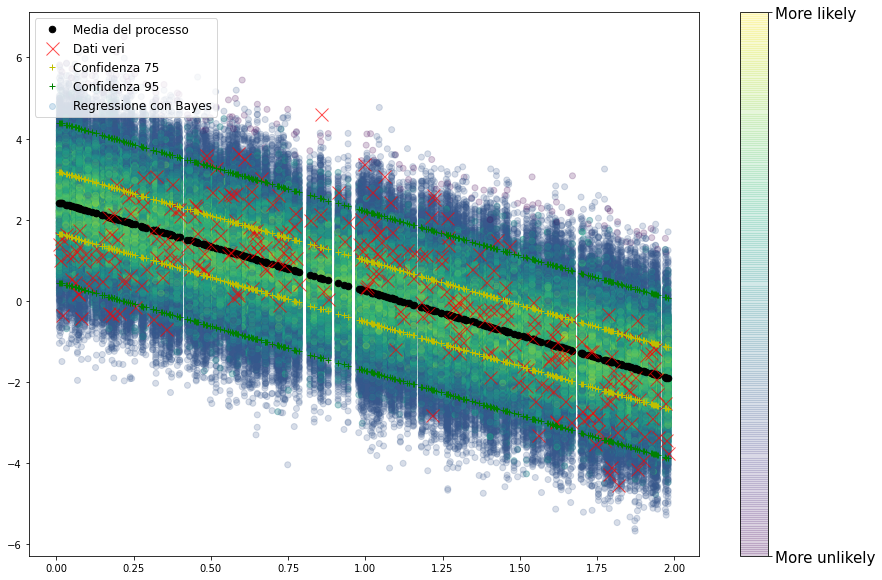

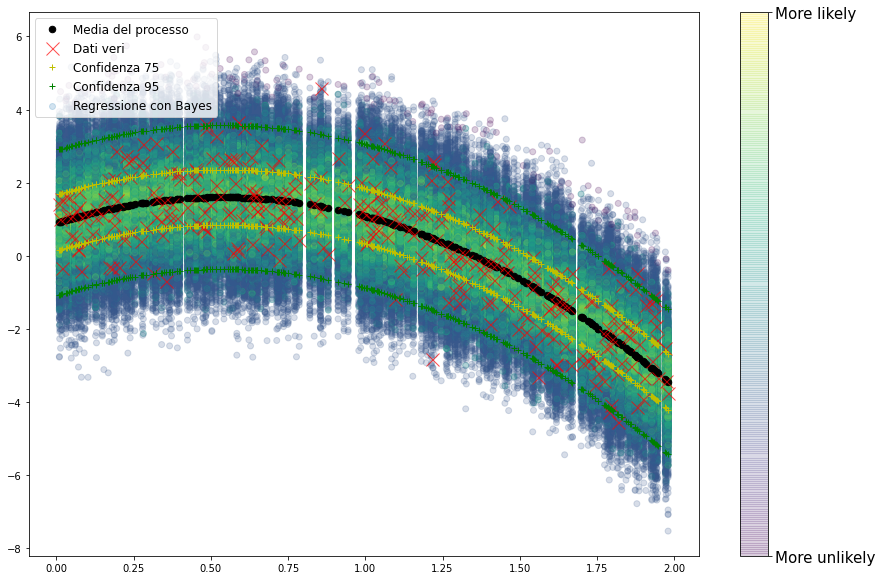

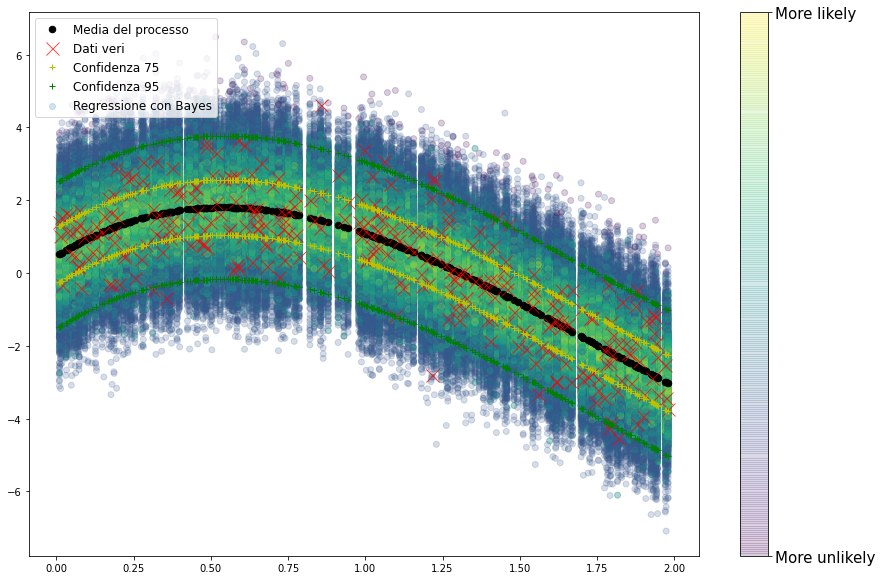

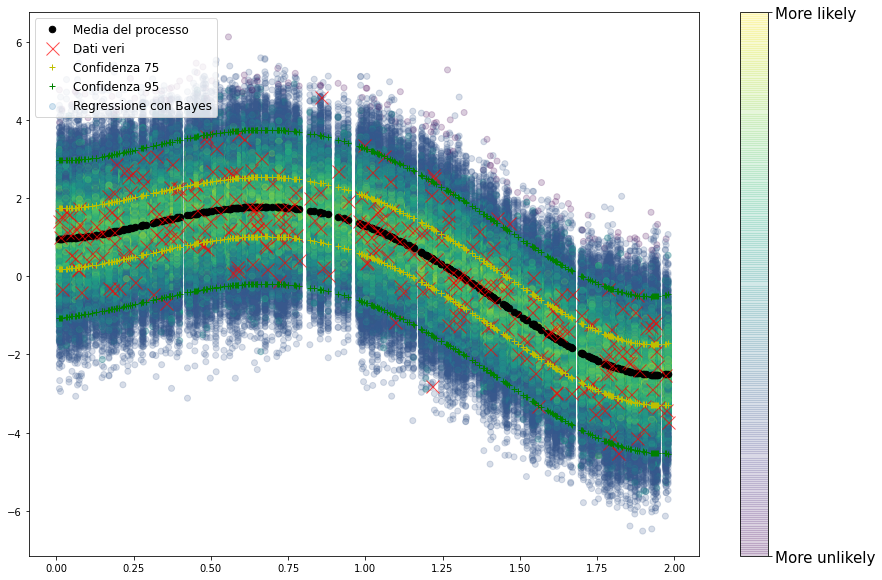

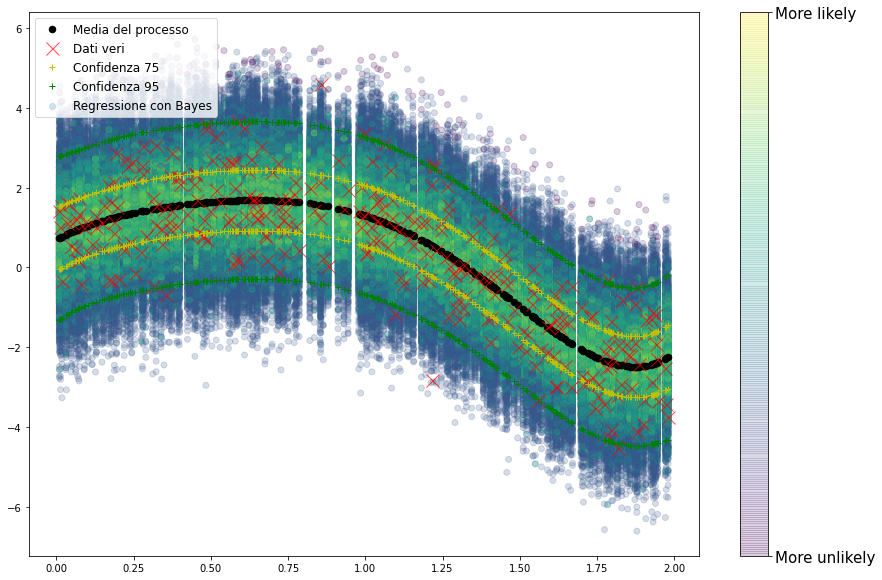

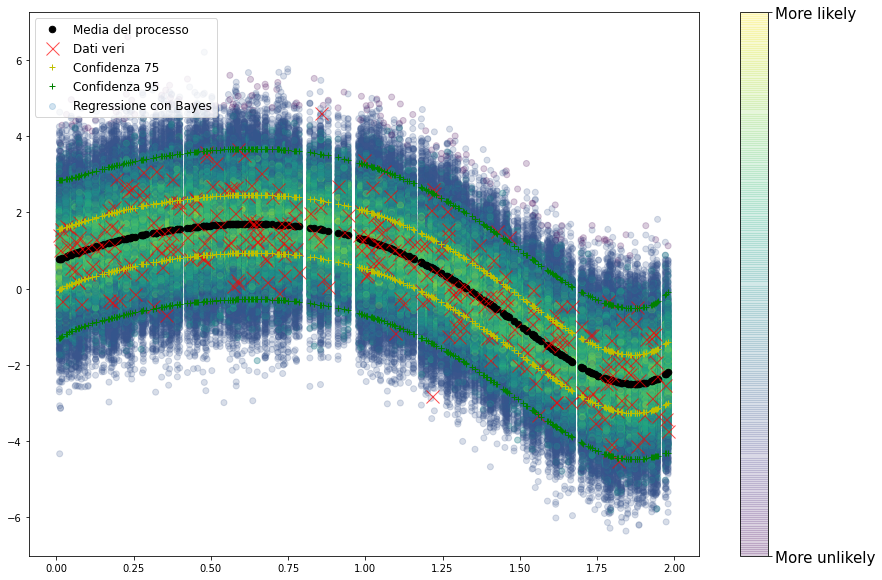

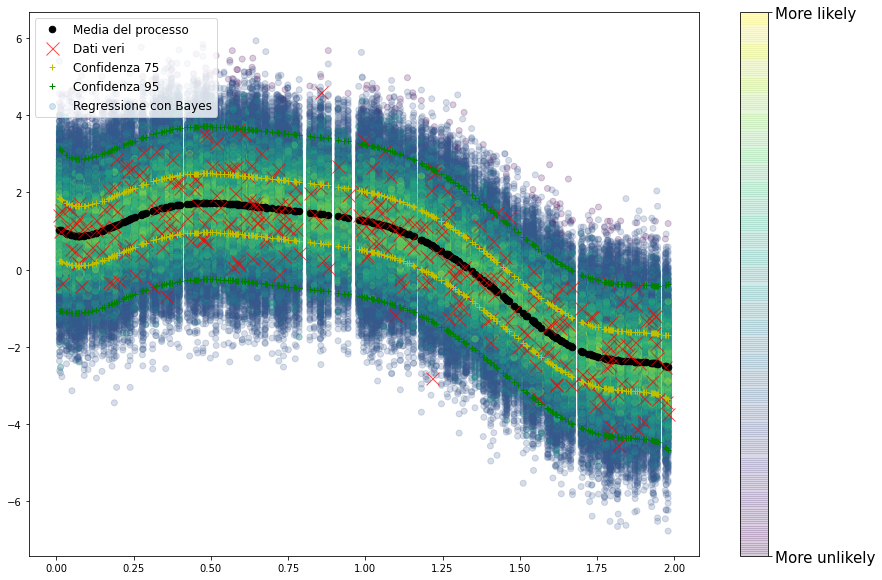

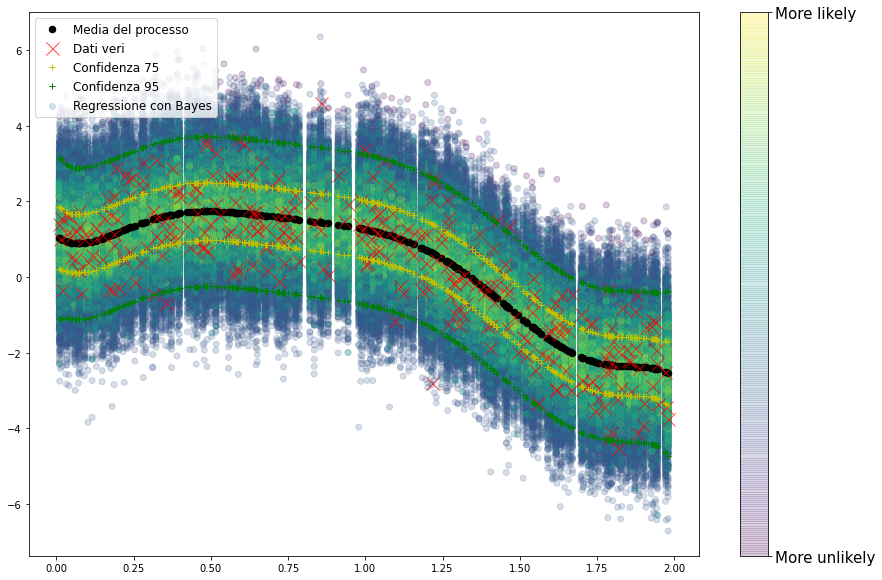

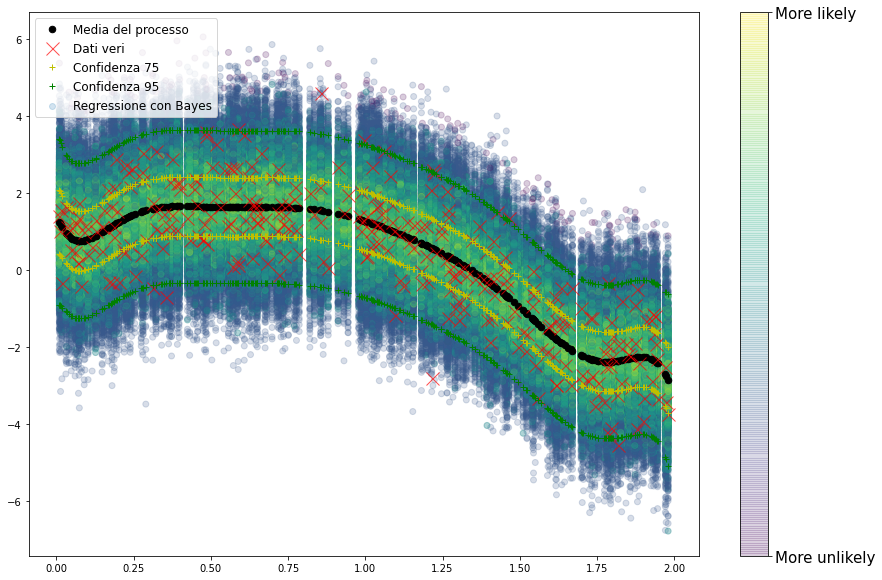

In [3]:
# Let's generate a really complex dataset to test the model

np.random.seed(42)
X = 2 * np.random.rand(300, 1)
y = -np.sin(X**2/5)+2.36*X+np.cos(X)-X**2/np.cos(np.sin(X))+ np.random.normal(loc=0,scale=1,size=(300,1))
X=np.c_[np.ones(len(X)),X]
highest_degree_polynomial=10
for d in range(1,highest_degree_polynomial):
  bayes_reg=PolynomialBayesianRegression(deg=d)
  bayes_reg.fit(X[:,-1:],y)
  bayes_reg.plotter()

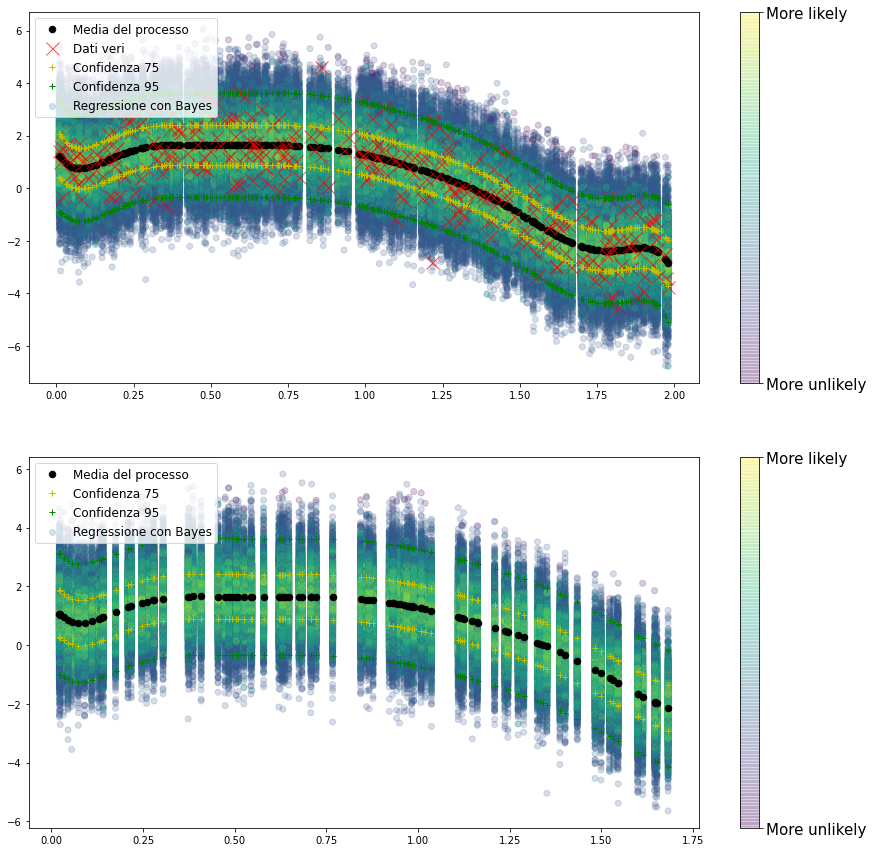

In [6]:
# Let's try with some out_of sample instances (this uses the parameters of the last model we have just trained)

np.random.seed(58)
X_test = 1.7 * np.random.rand(100, 1)
bayes_reg.predict(X_test)
bayes_reg.plotter("Both")